# Basic RSI strategy

## Single backtest

In [1]:
import numpy as np
import pandas as pd

In [2]:
import vectorbtpro as vbt

vbt.settings.set_theme('dark')

In [3]:
data = vbt.BinanceData.fetch('BTCUSDT')
data

0it [00:00, ?it/s]

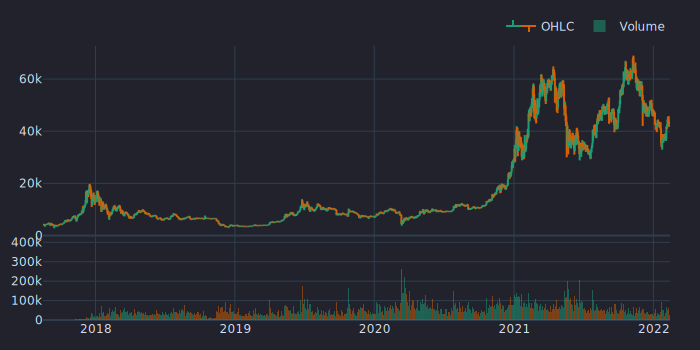

In [4]:
data.data['BTCUSDT'].vbt.ohlcv.plot().show_svg()

In [5]:
data.data['BTCUSDT'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1642 entries, 2017-08-17 00:00:00+00:00 to 2022-02-13 00:00:00+00:00
Freq: D
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Open                1642 non-null   float64            
 1   High                1642 non-null   float64            
 2   Low                 1642 non-null   float64            
 3   Close               1642 non-null   float64            
 4   Volume              1642 non-null   float64            
 5   Close time          1642 non-null   datetime64[ns, UTC]
 6   Quote volume        1642 non-null   float64            
 7   Number of trades    1642 non-null   int64              
 8   Taker base volume   1642 non-null   float64            
 9   Taker quote volume  1642 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(8), int64(1)
memory usage: 141.1 KB


In [6]:
open_price = data.get('Open')
close_price = data.get('Close')

In [7]:
vbt.RSI

vectorbtpro.indicators.custom.RSI

In [8]:
vbt.talib('RSI')

vectorbtpro.indicators.factory.talib.RSI

In [9]:
vbt.ta('RSIIndicator')

vectorbtpro.indicators.factory.ta.RSIIndicator

In [10]:
vbt.pandas_ta('RSI')

vectorbtpro.indicators.factory.pandas_ta.RSI

In [11]:
help(vbt.RSI.run)

Help on method run:

run(close, window=Default(value=14), ewm=Default(value=False), short_name='rsi', hide_params=None, hide_default=True, **kwargs) method of vectorbtpro.generic.analyzable.MetaAnalyzable instance
    Run `RSI` indicator.
    
    * Inputs: `close`
    * Parameters: `window`, `ewm`
    * Outputs: `rsi`
    
    Pass a list of parameter names as `hide_params` to hide their column levels.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `vectorbtpro.indicators.factory.run_pipeline`.



In [12]:
rsi = vbt.RSI.run(open_price)
rsi

In [13]:
rsi.rsi

Open time
2017-08-17 00:00:00+00:00          NaN
2017-08-18 00:00:00+00:00          NaN
2017-08-19 00:00:00+00:00          NaN
2017-08-20 00:00:00+00:00          NaN
2017-08-21 00:00:00+00:00          NaN
                               ...    
2022-02-09 00:00:00+00:00    79.688626
2022-02-10 00:00:00+00:00    81.235761
2022-02-11 00:00:00+00:00    75.071213
2022-02-12 00:00:00+00:00    67.640864
2022-02-13 00:00:00+00:00    65.694989
Freq: D, Name: Open, Length: 1642, dtype: float64

In [14]:
entries = rsi.rsi.vbt.crossed_below(30)
entries

Open time
2017-08-17 00:00:00+00:00    False
2017-08-18 00:00:00+00:00    False
2017-08-19 00:00:00+00:00    False
2017-08-20 00:00:00+00:00    False
2017-08-21 00:00:00+00:00    False
                             ...  
2022-02-09 00:00:00+00:00    False
2022-02-10 00:00:00+00:00    False
2022-02-11 00:00:00+00:00    False
2022-02-12 00:00:00+00:00    False
2022-02-13 00:00:00+00:00    False
Freq: D, Name: Open, Length: 1642, dtype: bool

In [15]:
exits = rsi.rsi.vbt.crossed_above(70)
exits

Open time
2017-08-17 00:00:00+00:00    False
2017-08-18 00:00:00+00:00    False
2017-08-19 00:00:00+00:00    False
2017-08-20 00:00:00+00:00    False
2017-08-21 00:00:00+00:00    False
                             ...  
2022-02-09 00:00:00+00:00    False
2022-02-10 00:00:00+00:00    False
2022-02-11 00:00:00+00:00    False
2022-02-12 00:00:00+00:00    False
2022-02-13 00:00:00+00:00    False
Freq: D, Name: Open, Length: 1642, dtype: bool

In [16]:
entries = rsi.rsi_crossed_below(30)
exits = rsi.rsi_crossed_above(70)

In [17]:
def plot_rsi(rsi, entries, exits):
    fig = rsi.plot()
    entries.vbt.signals.plot_as_entry_markers(rsi.rsi, fig=fig)
    exits.vbt.signals.plot_as_exit_markers(rsi.rsi, fig=fig)
    return fig

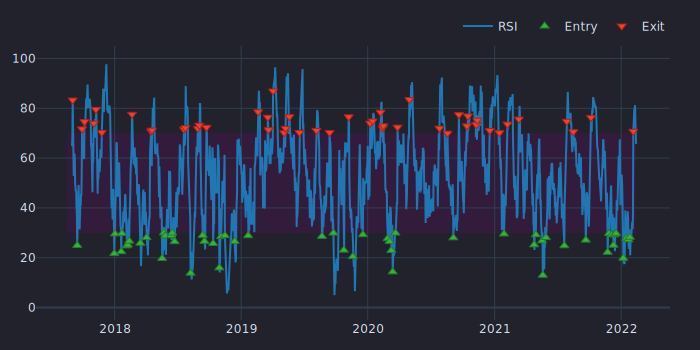

In [18]:
plot_rsi(rsi, entries, exits).show_svg()

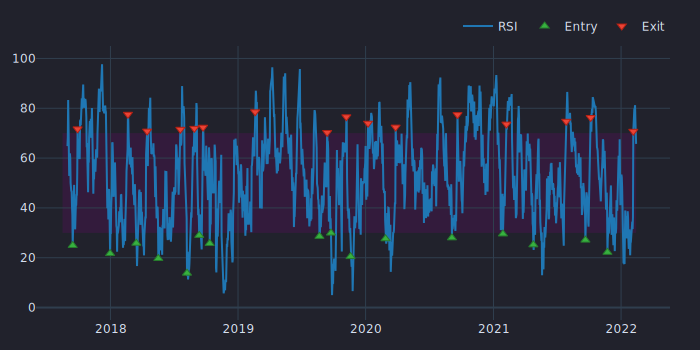

In [19]:
clean_entries, clean_exits = entries.vbt.signals.clean(exits)

plot_rsi(rsi, clean_entries, clean_exits).show_svg()

In [20]:
clean_entries.vbt.signals.total()

16

In [21]:
clean_exits.vbt.signals.total()

16

In [22]:
ranges = clean_entries.vbt.signals.between_ranges(other=clean_exits)
ranges.duration.mean(wrap_kwargs=dict(to_timedelta=True))

Timedelta('42 days 04:30:00')

In [23]:
pf = vbt.Portfolio.from_signals(
    close=close_price, 
    entries=clean_entries, 
    exits=clean_exits,
    size=100,
    size_type='value',
    init_cash='auto'
)
pf

In [24]:
pf.stats()

Start                         2017-08-17 00:00:00+00:00
End                           2022-02-13 00:00:00+00:00
Period                               1642 days 00:00:00
Start Value                                  157.043476
End Value                                    110.088814
Total Return [%]                             -29.899149
Benchmark Return [%]                         890.291196
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               58.04434
Max Drawdown Duration                1499 days 00:00:00
Total Trades                                         16
Total Closed Trades                                  16
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       50.0
Best Trade [%]                                35.794383
Worst Trade [%]                              -37

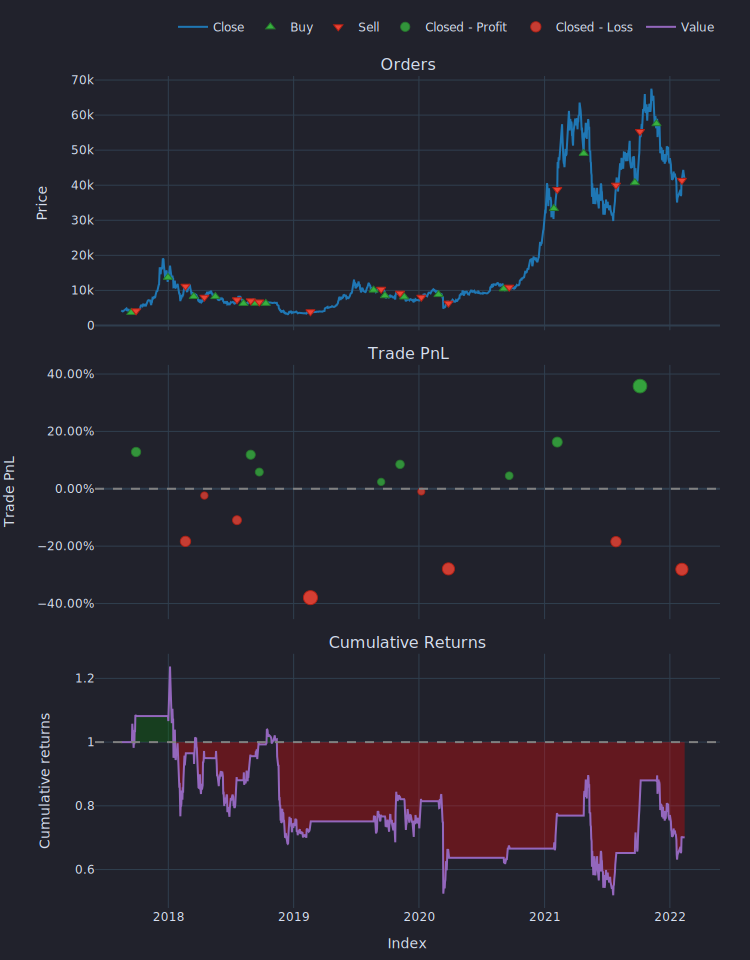

In [25]:
pf.plot(settings=dict(bm_returns=False)).show_svg()

## Multiple backtests

### Using for-loop

In [26]:
def test_rsi(window=14, ewm=False, lower_th=30, upper_th=70):
    rsi = vbt.RSI.run(open_price, window=window, ewm=ewm)
    entries = rsi.rsi_crossed_below(lower_th)
    exits = rsi.rsi_crossed_above(upper_th)
    pf = vbt.Portfolio.from_signals(
        close=close_price, 
        entries=entries, 
        exits=exits,
        size=100,
        size_type='value',
        init_cash='auto')
    return pf.stats([
        'total_return', 
        'total_trades', 
        'win_rate', 
        'expectancy'
    ])

In [27]:
test_rsi()

Total Return [%]   -29.899149
Total Trades               16
Win Rate [%]             50.0
Expectancy          -2.934666
dtype: object

In [28]:
test_rsi(lower_th=20, upper_th=80)

Total Return [%]    63.109058
Total Trades                8
Win Rate [%]             75.0
Expectancy           8.885842
dtype: object

In [29]:
from itertools import product

lower_ths = range(20, 31)
upper_ths = range(70, 81)
th_combs = list(product(lower_ths, upper_ths))
len(th_combs)

121

In [30]:
comb_stats = [
    test_rsi(lower_th=lower_th, upper_th=upper_th)
    for lower_th, upper_th in th_combs
]

In [31]:
comb_stats_df = pd.DataFrame(comb_stats)
comb_stats_df

,Total Return [%],Total Trades,Win Rate [%],Expectancy
0,-8.382186,9,44.444444,-1.293449
1,-4.870741,9,66.666667,-0.737520
2,15.709898,9,77.777778,1.955672
3,49.249425,9,66.666667,6.239087
4,59.319132,9,66.666667,7.454925
...,...,...,...,...
116,30.942689,14,50.000000,2.471356
117,15.590047,13,46.153846,1.404528
118,10.113272,12,41.666667,1.194345
119,22.664826,12,50.000000,2.436246


In [32]:
comb_stats_df.index = pd.MultiIndex.from_tuples(
    th_combs, 
    names=['lower_th', 'upper_th'])
comb_stats_df

Total Return [%]  Total Trades  Win Rate [%]  Expectancy
lower_th upper_th                                                          
20       70               -8.382186             9     44.444444   -1.293449
         71               -4.870741             9     66.666667   -0.737520
         72               15.709898             9     77.777778    1.955672
         73               49.249425             9     66.666667    6.239087
         74               59.319132             9     66.666667    7.454925
...                             ...           ...           ...         ...
30       76               30.942689            14     50.000000    2.471356
         77               15.590047            13     46.153846    1.404528
         78               10.113272            12     41.666667    1.194345
         79               22.664826            12     50.000000    2.436246
         80               24.473476            12     50.000000    2.630658

[121 rows x 4 columns]

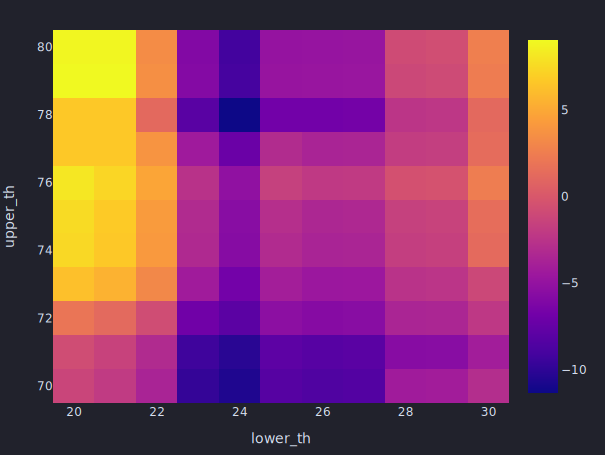

In [33]:
comb_stats_df['Expectancy'].vbt.heatmap().show_svg()

### Using columns

In [34]:
windows = list(range(8, 21))
ewms = [False, True]
lower_ths = list(range(20, 31))
upper_ths = list(range(70, 81))

In [35]:
rsi = vbt.RSI.run(
    open_price, 
    window=windows, 
    ewm=ewms, 
    param_product=True)
rsi.rsi.columns

MultiIndex([( 8, False),
            ( 8,  True),
            ( 9, False),
            ( 9,  True),
            (10, False),
            (10,  True),
            (11, False),
            (11,  True),
            (12, False),
            (12,  True),
            (13, False),
            (13,  True),
            (14, False),
            (14,  True),
            (15, False),
            (15,  True),
            (16, False),
            (16,  True),
            (17, False),
            (17,  True),
            (18, False),
            (18,  True),
            (19, False),
            (19,  True),
            (20, False),
            (20,  True)],
           names=['rsi_window', 'rsi_ewm'])

In [36]:
lower_ths_prod, upper_ths_prod = zip(*product(lower_ths, upper_ths))
len(lower_ths_prod)

121

In [37]:
len(upper_ths_prod)

121

In [38]:
lower_th_index = pd.Index(lower_ths_prod, name='lower_th')
entries = rsi.rsi_crossed_below(lower_th_index)
entries.columns

MultiIndex([(20,  8, False),
            (20,  8,  True),
            (20,  9, False),
            (20,  9,  True),
            (20, 10, False),
            (20, 10,  True),
            (20, 11, False),
            (20, 11,  True),
            (20, 12, False),
            (20, 12,  True),
            ...
            (30, 16, False),
            (30, 16,  True),
            (30, 17, False),
            (30, 17,  True),
            (30, 18, False),
            (30, 18,  True),
            (30, 19, False),
            (30, 19,  True),
            (30, 20, False),
            (30, 20,  True)],
           names=['lower_th', 'rsi_window', 'rsi_ewm'], length=3146)

In [39]:
upper_th_index = pd.Index(upper_ths_prod, name='upper_th')
exits = rsi.rsi_crossed_above(upper_th_index)
exits.columns

MultiIndex([(70,  8, False),
            (70,  8,  True),
            (70,  9, False),
            (70,  9,  True),
            (70, 10, False),
            (70, 10,  True),
            (70, 11, False),
            (70, 11,  True),
            (70, 12, False),
            (70, 12,  True),
            ...
            (80, 16, False),
            (80, 16,  True),
            (80, 17, False),
            (80, 17,  True),
            (80, 18, False),
            (80, 18,  True),
            (80, 19, False),
            (80, 19,  True),
            (80, 20, False),
            (80, 20,  True)],
           names=['upper_th', 'rsi_window', 'rsi_ewm'], length=3146)

In [40]:
pf = vbt.Portfolio.from_signals(
    close=close_price, 
    entries=entries, 
    exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)
pf

In [41]:
stats_df = pf.stats([
    'total_return', 
    'total_trades', 
    'win_rate', 
    'expectancy'
], agg_func=None)
stats_df

Total Return [%]  Total Trades  \
lower_th upper_th rsi_window rsi_ewm                                   
20       70       8          False          -24.704302            27   
                             True             0.559616            26   
                  9          False          -48.763162            22   
                             True            -2.887971            22   
                  10         False          -54.089211            16   
...                                                ...           ...   
30       80       18         True            30.809343             8   
                  19         False           -0.220692             5   
                             True            52.467971             8   
                  20         False          -36.624557             4   
                             True            34.749454             8   

                                      Win Rate [%]  Expectancy  
lower_th upper_th rsi_window rsi_ewm                            
20       70       8          False       51.851852   -1.212025  
                             True        61.538462    0.024203  
                  9          False       50.000000   -4.100151  
                             True        63.636364   -0.137642  
                  10         False       56.250000   -6.306094  
...                                            ...         ...  
30       80       18         True        57.142857    6.865879  
                  19         False       75.000000    6.385719  
                             True        57.142857    9.508749  
                  20         False       33.333333  -16.159733  
                             True        57.142857    7.032204  

[3146 rows x 4 columns]

In [42]:
stats_df['Expectancy'].groupby('rsi_window').mean()

rsi_window
8    -0.118821
9    -1.576580
10   -3.561112
11   -3.624169
12   -3.422694
13    0.289282
14   -0.399145
15    2.395380
16    2.754128
17    5.946845
18    3.903563
19    3.879639
20    4.638417
Name: Expectancy, dtype: float64

In [43]:
stats_df.sort_values(by='Expectancy', ascending=False).head()

,,,,Total Return [%],Total Trades,Win Rate [%],Expectancy
lower_th,upper_th,rsi_window,rsi_ewm,,,,
23,74,20,True,157.766285,8,71.428571,19.538712
24,74,20,True,157.766285,8,71.428571,19.538712
23,76,19,True,154.208536,8,71.428571,19.030462
24,75,20,True,154.208536,8,71.428571,19.030462
23,75,19,True,154.208536,8,71.428571,19.030462


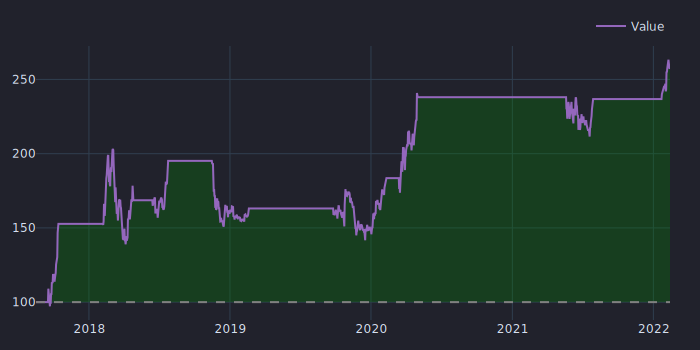

In [44]:
pf[(24, 74, 20, True)].plot_value().show_svg()

In [45]:
data = vbt.BinanceData.fetch(['BTCUSDT', 'ETHUSDT'])

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [46]:
open_price = data.get('Open')
close_price = data.get('Close')

In [47]:
rsi = vbt.RSI.run(
    open_price, 
    window=windows, 
    ewm=ewms, 
    param_product=True)
entries = rsi.rsi_crossed_below(lower_th_index)
exits = rsi.rsi_crossed_above(upper_th_index)
pf = vbt.Portfolio.from_signals(
    close=close_price, 
    entries=entries, 
    exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)
stats_df = pf.stats([
    'total_return', 
    'total_trades', 
    'win_rate', 
    'expectancy'
], agg_func=None)

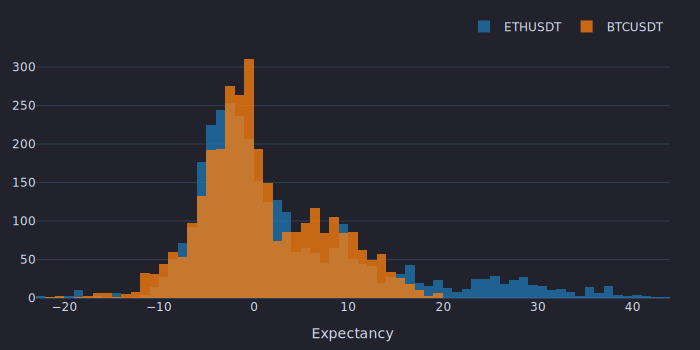

In [48]:
eth_mask = stats_df.index.get_level_values('symbol') == 'ETHUSDT'
btc_mask = stats_df.index.get_level_values('symbol') == 'BTCUSDT'
pd.DataFrame({
    'ETHUSDT': stats_df[eth_mask]['Expectancy'].values,
    'BTCUSDT': stats_df[btc_mask]['Expectancy'].values
}).vbt.histplot(xaxis=dict(title="Expectancy")).show_svg()